<font color='blue'> **01_watershed.ipynb_3099** </font> zz

In [1]:
import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.discretization import StructuredGrid
from typing import List, Tuple, Union ; from pathlib import Path ; import pickle ; import pandas as pd
from flopy.utils.gridintersect import GridIntersect ; from shapely.geometry import LineString, Polygon
import warnings ; warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
ref_data  = Path("E:/15_REPOS/00_BETAMI/bin/Flopy_Christianlangevin/01_ref_data_watershed") ;sim_data=Path("./01_RES") ;sim_data.mkdir(exist_ok=True)  
#ascii_file = pl("E:/15_REPOS/00_BETAMI/bin/Flopy_data/fine_topo.asc") 

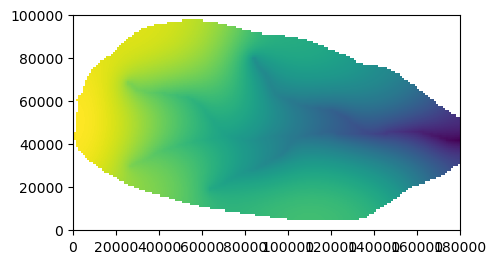

In [5]:
fine_topo = flopy.utils.Raster.load(ref_data / "fine_topo.tif")
fig = plt.figure(figsize=(5,5)) ; ax = fig.add_subplot() ; fine_topo.plot(ax=ax) ; plt.show(block=False)

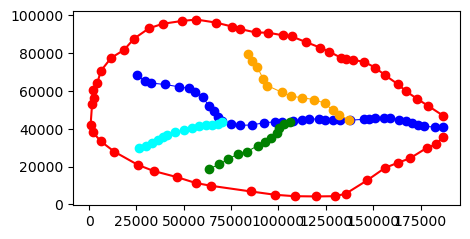

In [6]:
with open(ref_data/ "01_geometry", 'rb') as handle:
    geometry = pickle.load(handle) 
    
def string2geom(geostring: str,conversion: float = None,) -> List[tuple]:
    if conversion is None:         multiplier = 1.0
    else:         multiplier = float(conversion)
    res = []
    for line in geostring.split("\n"):
        line = line.split(" ") ;         x = float(line[0]) * multiplier ; y = float(line[1]) * multiplier ;         res.append((x, y))
    return res
Lx=180000 ;Ly=100000; dx=dy=2500.0 ;nrow=int(Ly/dy)+1 ;ncol=int(Lx/dx)+1 ; 
boundary_polygon = string2geom(geometry["boundary"])                           ; bp = np.array(boundary_polygon)
stream_segs      = (geometry["streamseg1"],geometry["streamseg2"],geometry["streamseg3"],geometry["streamseg4"])  
sgs = [string2geom(sg) for sg in stream_segs]

fig = plt.figure(figsize=(5,5))  ; ax = fig.add_subplot() ; ax.set_aspect("equal") ; riv_colors = ("blue", "cyan", "green", "orange", "red")
ax.plot(bp[:, 0], bp[:, 1], "ro-")
for idx, sg in enumerate(sgs):
    sa = np.array(sg)  ; ax.plot(sa[:, 0], sa[:, 1], color=riv_colors[idx], lw=0.75, marker="o")
# geo2 = pd.DataFrame(geometry,index=[1,2,3,4]) ; geo2.to_csv (sim_data/ "geometry.csv")  # 5 2749 1899 699 599 649

In [7]:
def set_structured_idomain(modelgrid: flopy.discretization.StructuredGrid,boundary: List[tuple]) -> None:
    if modelgrid.grid_type != "structured":
        raise ValueError(f"modelgrid must be 'structured' not '{modelgrid.grid_type}'")
    ix = GridIntersect(modelgrid, method="vertex", rtree=True)
    result = ix.intersect(Polygon(boundary))
    idx = [coords for coords in result.cellids]
    idx = np.array(idx, dtype=int)
    nr = idx.shape[0]
    if idx.ndim == 1:
        idx = idx.reshape((nr, 1))
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])
    idomain = np.zeros(modelgrid.shape[1:], dtype=int)
    idomain[idx] = 1
    idomain = idomain.reshape(modelgrid.shape)
    modelgrid.idomain = idomain
    return
working_grid = StructuredGrid(nlay=1,delr=np.full(ncol, dx),delc=np.full(nrow, dy),xoff=0.0,yoff=0.0,
                              top=np.full((nrow, ncol), 1000.0),botm=np.full((1, nrow, ncol), -100.0))
set_structured_idomain(working_grid, boundary_polygon)
print("grid data: ", Lx, Ly, nrow, ncol)

grid data:  180000 100000 41 73


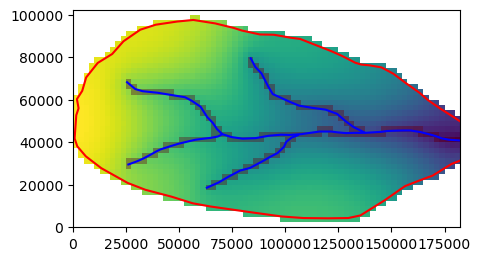

In [10]:
top_wg  = fine_topo.resample_to_grid(working_grid,band=fine_topo.bands[0],method="linear",extrapolate_edges=True)
def intersect_segments(modelgrid: Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid],
                       segments: List[List[tuple]]) -> Tuple[flopy.utils.GridIntersect, list, list]:
    ixs = flopy.utils.GridIntersect(modelgrid,method=modelgrid.grid_type)  ; cellids = []  ; lengths = []
    for sg in segments:
        v = ixs.intersect(LineString(sg), sort_by_cellid=True) ; cellids += v["cellids"].tolist()  ; lengths += v["lengths"].tolist()
    return ixs, cellids, lengths
ixs, cellids, lengths = intersect_segments(working_grid, sgs)  ; intersection_rg = np.zeros(working_grid.shape[1:])
for loc in cellids:     intersection_rg[loc] = 1
fig = plt.figure(figsize=(5,5))  ; ax = fig.add_subplot() ; pmv = flopy.plot.PlotMapView(modelgrid=working_grid)
ax.set_aspect("equal")           ; pmv.plot_array(top_wg) ; pmv.plot_array(intersection_rg,masked_values=[0,],alpha=0.2,cmap="Reds_r")
pmv.plot_inactive(color_noflow="white") ; ax.plot(bp[:, 0], bp[:, 1], "r-")   # ; plt.colorbar(??, fig)
for sg in sgs:
    sa = np.array(sg)  ; ax.plot(sa[:, 0], sa[:, 1], "b-")
plt.show(block=False)

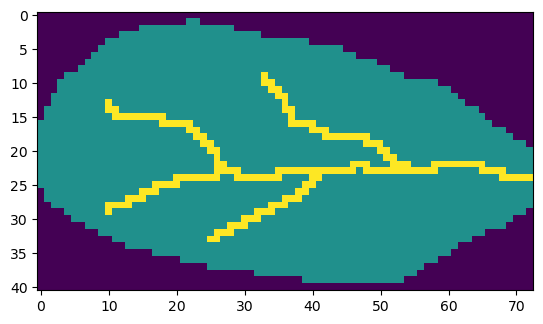

In [11]:
# print
river_locations = working_grid.idomain[0].copy() ; index = tuple(np.array(list(zip(*cellids))))    ;river_locations [index] = 2 
working_grid.idomain = river_locations.reshape(1, nrow, ncol)  ; plt.imshow(working_grid.idomain[0])

In [12]:
def build_drain_data(modelgrid: Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid],cellids: list,
                     lengths: list,leakance: float,elevation: np.ndarray,) -> List[tuple]:
    drn_data = []
    for cellid, length in zip(cellids, lengths):
        x = modelgrid.xcellcenters[cellid]    ; width = 5.0 + (14.0 / Lx) * (Lx - x)  ; conductance = leakance * length * width
        if not isinstance(cellid, tuple):
            cellid = (cellid,)
        drn_data.append((0, *cellid, elevation[cellid], conductance))
    return drn_data
nlay = 5 ; dv0 = 5.0
leakance = 1.0 / (0.5 * dv0)  ; drn_data = build_drain_data(working_grid,cellids,lengths,leakance,top_wg)  #; drn_data[:10]

In [13]:
def cell_areas(modelgrid: Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid]) -> np.ndarray:
    if modelgrid.grid_type == "structured":
        nrow, ncol = modelgrid.nrow, modelgrid.ncol ; areas = np.zeros((nrow, ncol), dtype=float)
        for r in range(nrow):
            for c in range(ncol): 
                cellid = (r, c) ; vertices = np.array(modelgrid.get_cell_vertices(cellid)) ; area = Polygon(vertices).area ; areas[cellid] = area
    elif modelgrid.grid_type == "vertex": 
        areas = np.zeros(modelgrid.ncpl, dtype=float)
        for idx in range(modelgrid.ncpl): 
            vertices = np.array(modelgrid.get_cell_vertices(idx))  ; area = Polygon(vertices).area ; areas[idx] = area
    else:   raise ValueError(+ f"{modelgrid.grid_type}")
    return areas

In [14]:
def build_groundwater_discharge_data(modelgrid: Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid],
                                     leakance: float,elevation: np.ndarray,) -> List[tuple]:
    areas = cell_areas(modelgrid)   ; drn_data = [] ; idomain = modelgrid.idomain[0]
    for idx in range(modelgrid.ncpl):
        if modelgrid.grid_type == "structured":  r, c = modelgrid.get_lrc(idx)[0][1:]  ; cellid = (r, c)
        else:                                    cellid = idx 
        area = areas[cellid]
        if idomain[cellid] == 1:
            conductance = leakance * area
            if not isinstance(cellid, tuple):    cellid = (cellid,)
            drn_data.append((0, *cellid, elevation[cellid] - 0.5, conductance, 1.0))
    return drn_data
gw_discharge_data = build_groundwater_discharge_data(working_grid,leakance,top_wg)  # gw_discharge_data[:10]

In [16]:
idomain = np.array([working_grid.idomain[0, :, :].copy() for k in range(nlay)])
strt    = np.array([top_wg.copy() for k in range(nlay)], dtype=float)
topc = np.zeros((nlay, nrow, ncol), dtype=float)   ; botm = np.zeros((nlay, nrow, ncol), dtype=float)
dv = dv0 ; topc[0] = top_wg.copy()  ; botm[0] = topc[0] - dv
for idx in range(1, nlay):  dv *= 1.5  ; topc[idx] = botm[idx - 1] ; botm[idx] = topc[idx] - dv
for k in range(nlay): print((topc[k] - botm[k]).mean())

5.0
7.5
11.25
16.875
25.3125


In [17]:
sim = flopy.mf6.MFSimulation(sim_ws=sim_data,exe_name="mf6",memory_print_option="summary",)

flopy.mf6.ModflowTdis(sim)
flopy.mf6.ModflowIms(sim,complexity="simple",print_option="SUMMARY",csv_outer_output_filerecord="outer.csv",
                           csv_inner_output_filerecord="inner.csv",linear_acceleration="bicgstab",outer_maximum=1000,inner_maximum=100,
                           outer_dvclose=1e-4,inner_dvclose=1e-5,preconditioner_levels=2,relaxation_factor=0.0)
gwf = flopy.mf6.ModflowGwf(sim,print_input=True,save_flows=True,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=dx,delc=dy,idomain=idomain,top=top_wg,botm=botm,xorigin=0.0,yorigin=0.0)
flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,icelltype=1,k=1.0)
flopy.mf6.ModflowGwfrcha(gwf,recharge=0.000001)
flopy.mf6.ModflowGwfdrn(gwf,maxbound=len(drn_data),stress_period_data=drn_data,pname="river",filename="drn_riv.drn")
flopy.mf6.ModflowGwfdrn(gwf,auxiliary=["depth"],auxdepthname="depth",maxbound=len(gw_discharge_data),
                                  stress_period_data=gw_discharge_data,pname="gwd",filename="drn_gwd.drn")
flopy.mf6.ModflowGwfoc(gwf,head_filerecord=f"{gwf.name}.hds",budget_filerecord=f"{gwf.name}.cbc",
                            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],printrecord=[("BUDGET", "ALL")]) ; 

#### Count the number of active cells

In [18]:
def get_model_cell_count(model: Union[flopy.mf6.ModflowGwf,flopy.mf6.ModflowGwt]) -> Tuple[int, int]:
    modelgrid = model.modelgrid
    if modelgrid.grid_type == "structured":
        nlay, nrow, ncol = modelgrid.nlay, modelgrid.nrow, modelgrid.ncol ; ncells = nlay * nrow * ncol ; idomain = modelgrid.idomain
        if idomain is None:             nactive = nlay * nrow * ncol
        else:                           nactive = np.count_nonzero(idomain == 1)
    elif modelgrid.grid_type == "vertex":
        nlay, ncpl = modelgrid.nlay, modelgrid.ncpl ; ncells = nlay * ncpl ;         idomain = modelgrid.idomain
        if idomain is None:             nactive = nlay * ncpl
        else:                           nactive = np.count_nonzero(idomain == 1)
    else:         raise ValueError(f"modelgrid grid type '{modelgrid.grid_type}' not supported")
    return ncells, nactive
def get_simulation_cell_count(simulation: flopy.mf6.MFSimulation,) -> Tuple[int, int]:
    ncells = 0 ;     nactive = 0
    for model_name in simulation.model_names:
        model = simulation.get_model(model_name) ; i, j = get_model_cell_count(model) ; ncells += i ; nactive += j
    return ncells, nactive
ncells, nactive = get_simulation_cell_count(sim) ;  print("nr. of cells:", ncells, ", active:", nactive)

nr. of cells: 14965 , active: 9595


In [19]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...
